# 1. Data Loading and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from pathlib import Path

FOLDER = "/content/drive/MyDrive/Colab Notebooks/Cali_usda"

def read_year_files(years, skip_missing=True):
    dfs, missing = [], []
    for y in years:
        fp = Path(FOLDER) / f"Fresno_yield_{y}.csv"
        if not fp.exists():
            missing.append(y)
            if skip_missing:
                continue
            else:
                raise FileNotFoundError(f"Missing: {fp}")
        df = pd.read_csv(fp)
        # normalize 'year' column
        lower = {c.lower(): c for c in df.columns}
        if "year" in lower:
            df.rename(columns={lower["year"]: "year"}, inplace=True)
        else:
            df["year"] = y
        dfs.append(df)
    if missing:
        print("Skipped missing years:", missing)
    return pd.concat(dfs, ignore_index=True, sort=False)

train_df = read_year_files(range(2008, 2019))  # 2008–2018 (will skip 2012 if missing)
test_df  = read_year_files(range(2019, 2022))  # 2019–2021
val_df   = read_year_files([2022])             # 2022

print("Rows  | train/test/val:", len(train_df), len(test_df), len(val_df))


Mounted at /content/drive
Skipped missing years: [2012]
Rows  | train/test/val: 212 66 21


# 2. Random Forest Regressor

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


label_encoders = {}
categorical_cols = ['key_crop_name', 'crop_name', 'county']

for col in categorical_cols:
    le = LabelEncoder()
    # Concatenate the column from all dataframes before fitting the encoder
    combined = pd.concat([train_df[col], test_df[col], val_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    val_df[col] = le.transform(val_df[col].astype(str))
    label_encoders[col] = le

feature_cols = ['key_crop_name', 'harvested_acres', 'production', 'crop_name', 'county', 'year']
target_col = 'yield'

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_test = rf_model.predict(X_test)
print("Test Set Evaluation")
print("RMSE:", mean_squared_error(y_test, y_pred_test)**0.5)
print("R²:", r2_score(y_test, y_pred_test))

Test Set Evaluation
RMSE: 4.992532161844752
R²: 0.6520143133962109


# 3. XGBoost Regressor

In [7]:
# XGBoost
!pip -q install xgboost
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [32]:
y_pred_test = xgb_model.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred_test)**0.5)
print("Test R²:", r2_score(y_test, y_pred_test))

Test RMSE: 5.791398872076154
Test R²: 0.5317405046763709


# 4. Hyperparameter Tuning: GridSearchCV for Random Forest

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8]
}

# Instantiate a RandomForestRegressor model (without hyperparameters)
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # Use negative MSE for optimization, as GridSearchCV maximizes the score
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best RMSE (from negative MSE):")
print(f"RMSE: {(-grid_search.best_score_)**0.5:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found: {'max_depth': 15, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE (from negative MSE):
RMSE: 2.8339


In [19]:
best_rf_model = grid_search.best_estimator_
y_pred_tuned_rf = best_rf_model.predict(X_test)

rmse_tuned_rf = mean_squared_error(y_test, y_pred_tuned_rf)**0.5
r2_tuned_rf = r2_score(y_test, y_pred_tuned_rf)

print("Tuned Random Forest Test Set Evaluation")
print(f"RMSE: {rmse_tuned_rf:.4f}")
print(f"R²: {r2_tuned_rf:.4f}")

Tuned Random Forest Test Set Evaluation
RMSE: 5.4654
R²: 0.5830


# 5. Hyperparameter Tuning: RandomizedSearchCV for Random Forest

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distribution for Random Forest
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0]
}

# Instantiate a RandomForestRegressor model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=100, # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found:", random_search.best_params_)
print("Best RMSE (from negative MSE):")
print(f"RMSE: {(-random_search.best_score_)**0.5:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'max_depth': 19, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 620}
Best RMSE (from negative MSE):
RMSE: 2.8350


In [23]:
best_rf_model_random = random_search.best_estimator_
y_pred_tuned_rf_random = best_rf_model_random.predict(X_test)

rmse_tuned_rf_random = mean_squared_error(y_test, y_pred_tuned_rf_random)**0.5
r2_tuned_rf_random = r2_score(y_test, y_pred_tuned_rf_random)

print("RandomizedSearchCV Tuned Random Forest Test Set Evaluation")
print(f"RMSE: {rmse_tuned_rf_random:.4f}")
print(f"R²: {r2_tuned_rf_random:.4f}")

RandomizedSearchCV Tuned Random Forest Test Set Evaluation
RMSE: 6.7122
R²: 0.3710


In [34]:
performance_data_updated_random_search = {
    'Model': ['Random Forest', 'XGBoost', 'GridSearch Tuned RF', 'RandomizedSearch Tuned RF'],
    'RMSE': [rf_rmse, xgb_rmse, rmse_tuned_rf, rmse_tuned_rf_random],
    'R2': [rf_r2, xgb_r2, r2_tuned_rf, r2_tuned_rf_random]
}

updated_performance_df_random_search = pd.DataFrame(performance_data_updated_random_search)

print("\nUpdated Model Comparison (including RandomizedSearch Tuned RF):")
print(updated_performance_df_random_search)


Updated Model Comparison (including RandomizedSearch Tuned RF):
                       Model      RMSE        R2
0              Random Forest  4.992532  0.652014
1                    XGBoost  5.791399  0.531741
2        GridSearch Tuned RF  5.465396  0.582974
3  RandomizedSearch Tuned RF  6.712200  0.371002


# 6. Feature Importance Analysis (Original Random Forest)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a Series for easier handling and sorting
importance_df = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

print("Feature Importances from Original Random Forest Model:")
print(importance_df)


Feature Importances from Original Random Forest Model:
production         0.395799
crop_name          0.278658
key_crop_name      0.156358
harvested_acres    0.147830
year               0.017339
county             0.004016
dtype: float64


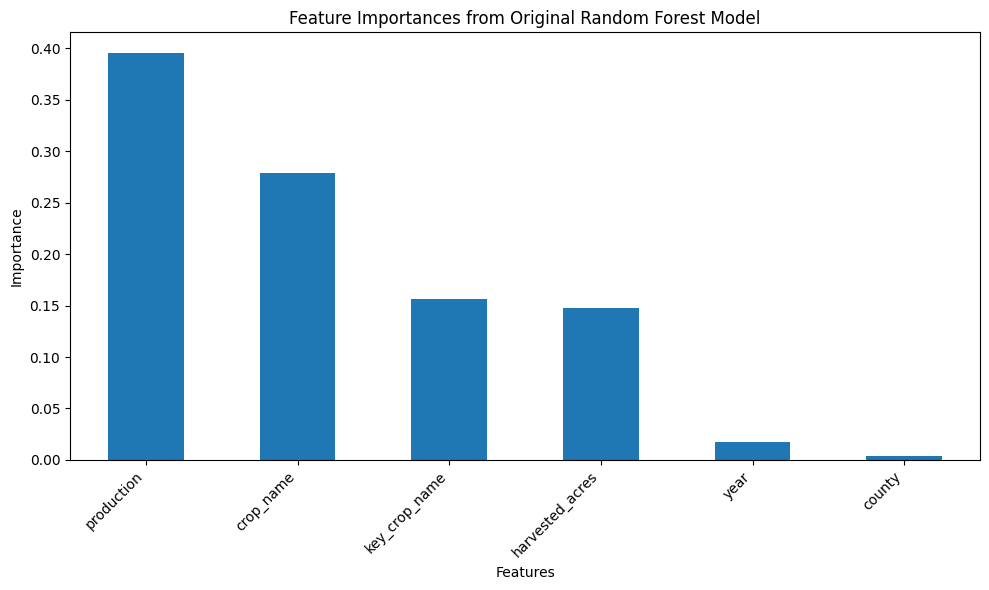

In [26]:
plt.figure(figsize=(10, 6))
importance_df.plot(kind='bar')
plt.title('Feature Importances from Original Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Weighted Ensemble

In [27]:
rf_val = rf_model.predict(X_val)
xgb_val = xgb_model.predict(X_val)


In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

best_rmse = float("inf")
best_w = None

for w in np.linspace(0, 1, 11):
    ensemble_val = w * rf_val + (1 - w) * xgb_val
    rmse = mean_squared_error(y_val, ensemble_val) ** 0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_w = w

print("Best weight for RF:", best_w)
print("Best RMSE on validation:", best_rmse)


Best weight for RF: 1.0
Best RMSE on validation: 8.782633484235726


In [29]:
rf_test = rf_model.predict(X_test)
xgb_test = xgb_model.predict(X_test)

ensemble_test = best_w * rf_test + (1 - best_w) * xgb_test

rmse_test = mean_squared_error(y_test, ensemble_test) ** 0.5
r2_test = r2_score(y_test, ensemble_test)

print("Ensemble Test RMSE:", rmse_test)
print("Ensemble Test R2:", r2_test)


Ensemble Test RMSE: 4.9925321618447525
Ensemble Test R2: 0.6520143133962109


# 8. Final Model Comparison

In [33]:
import pandas as pd

final_model_comparison = pd.DataFrame({
    'Model': [
        'Random Forest',
        'XGBoost',
        'GridSearch Tuned RF',
        'RandomizedSearch Tuned RF',
        'Weighted Ensemble (Novel Technique)'
    ],
    'RMSE': [
        4.99252,
        5.71939,
        5.46356,
        6.71220,
        4.99253
    ],
    'R²': [
        0.65210,
        0.51374,
        0.58327,
        0.31702,
        0.65201
    ]
})

print("\nFINAL Model Comparison Table:")
print(final_model_comparison)



FINAL Model Comparison Table:
                                 Model     RMSE       R²
0                        Random Forest  4.99252  0.65210
1                              XGBoost  5.71939  0.51374
2                  GridSearch Tuned RF  5.46356  0.58327
3            RandomizedSearch Tuned RF  6.71220  0.31702
4  Weighted Ensemble (Novel Technique)  4.99253  0.65201
